In [2]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)

In [1]:
from time import time
#import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn import metrics
from keras.datasets import fashion_mnist

In [3]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [4]:
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
n_clusters = len(np.unique(y))
x.shape

(70000, 784)

In [6]:
kmeans = KMeans(n_clusters=n_clusters, n_init=1)
y_pred_kmeans = kmeans.fit_predict(x)

In [7]:
metrics.accuracy_score(y, y_pred_kmeans)

0.07027142857142857

In [8]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(learning_rate=1.0, momentum=0.9)
pretrain_epochs = 30
batch_size = 256
save_dir = './results'

In [9]:
autoencoder, encoder = autoencoder(dims, init=init)

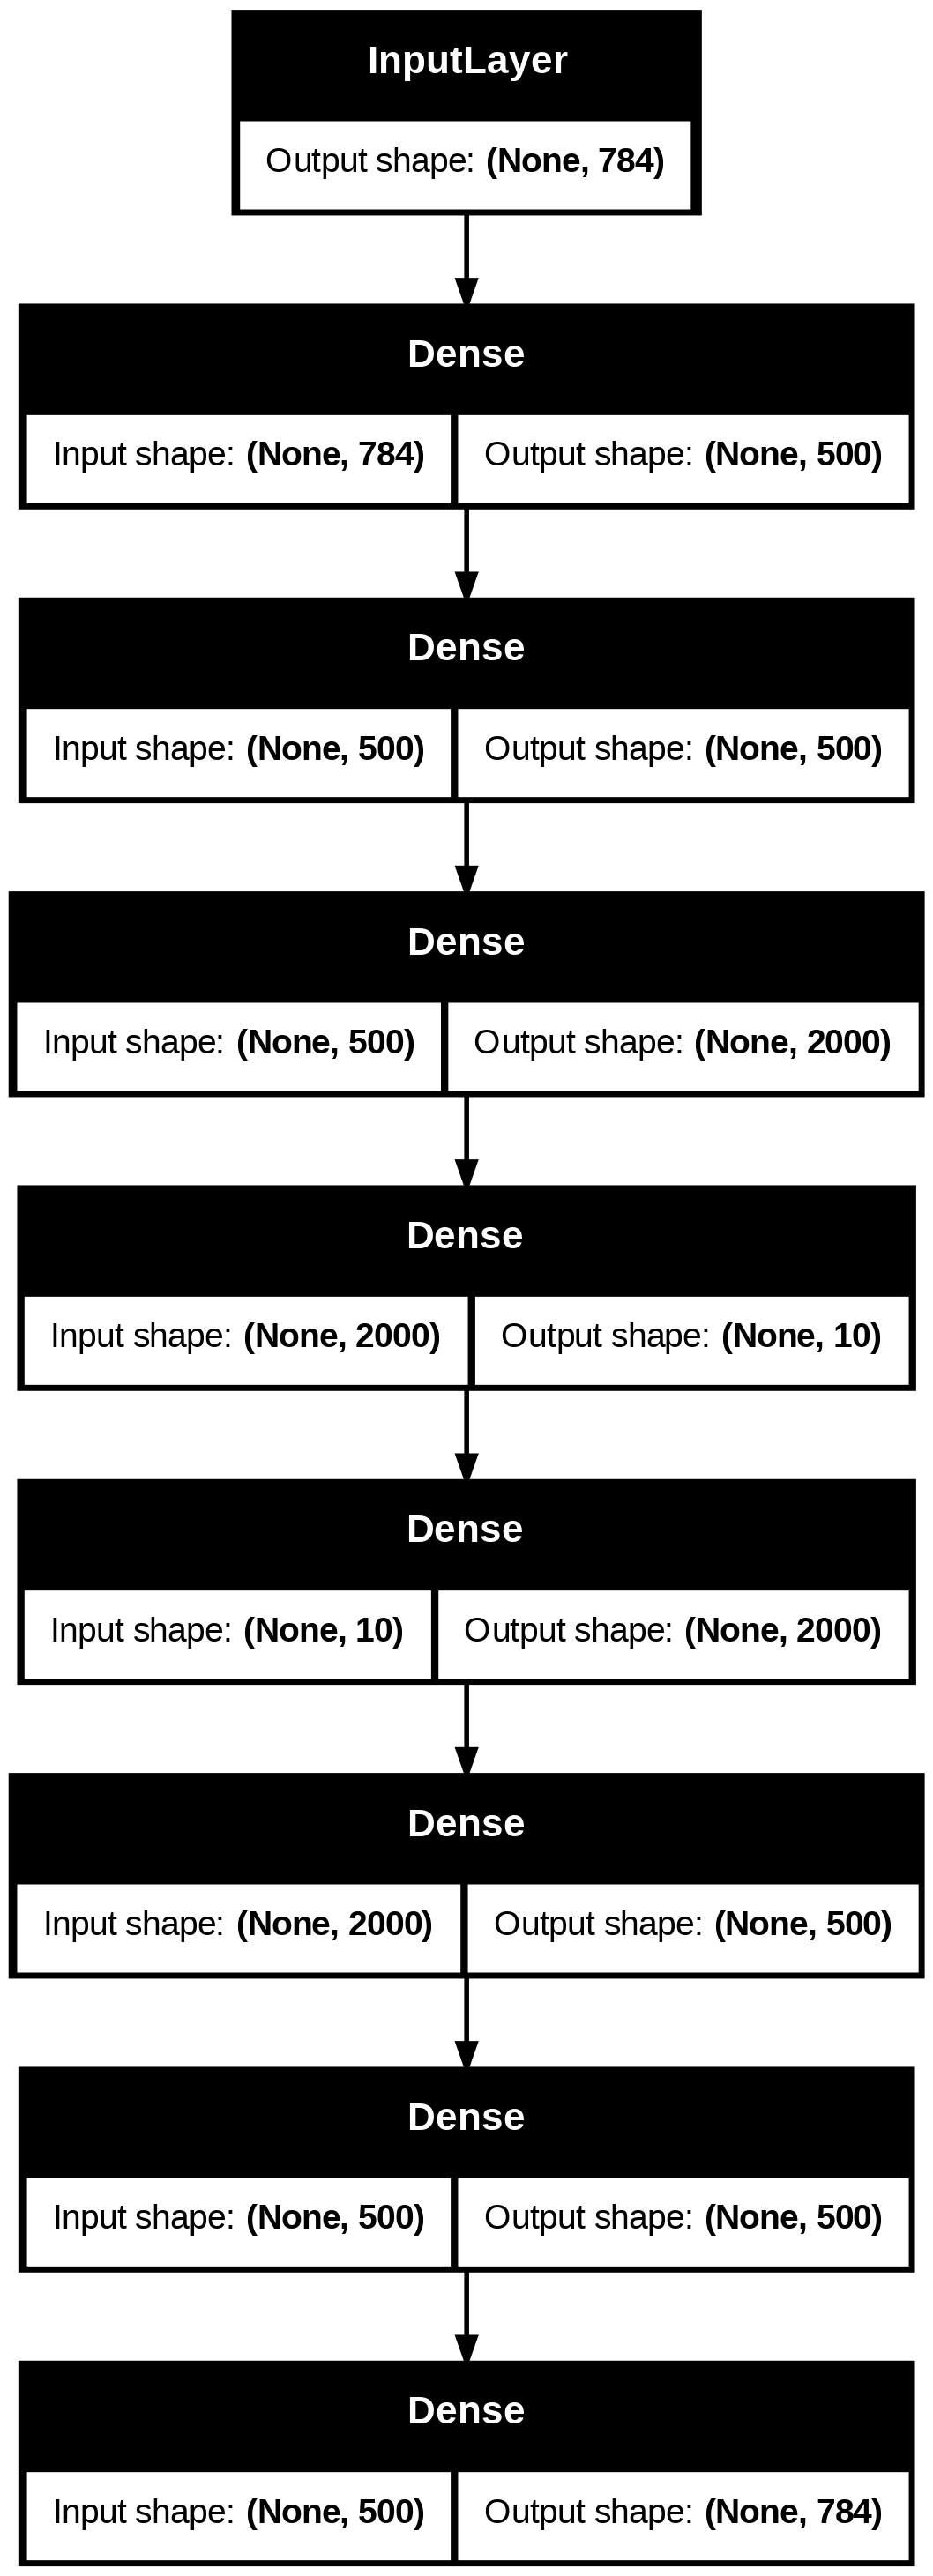

In [10]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

In [11]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
#autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0960
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0356
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0263
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0234
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0219
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0210
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0197
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0189
Epoch 9/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0183
Epoch 10/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0176
Epoch 11/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0170
Epoch 12/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165
Epoch 13/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0160
Epoch 14/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0156
Epoch 15/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - l

In [12]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
       # self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [13]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

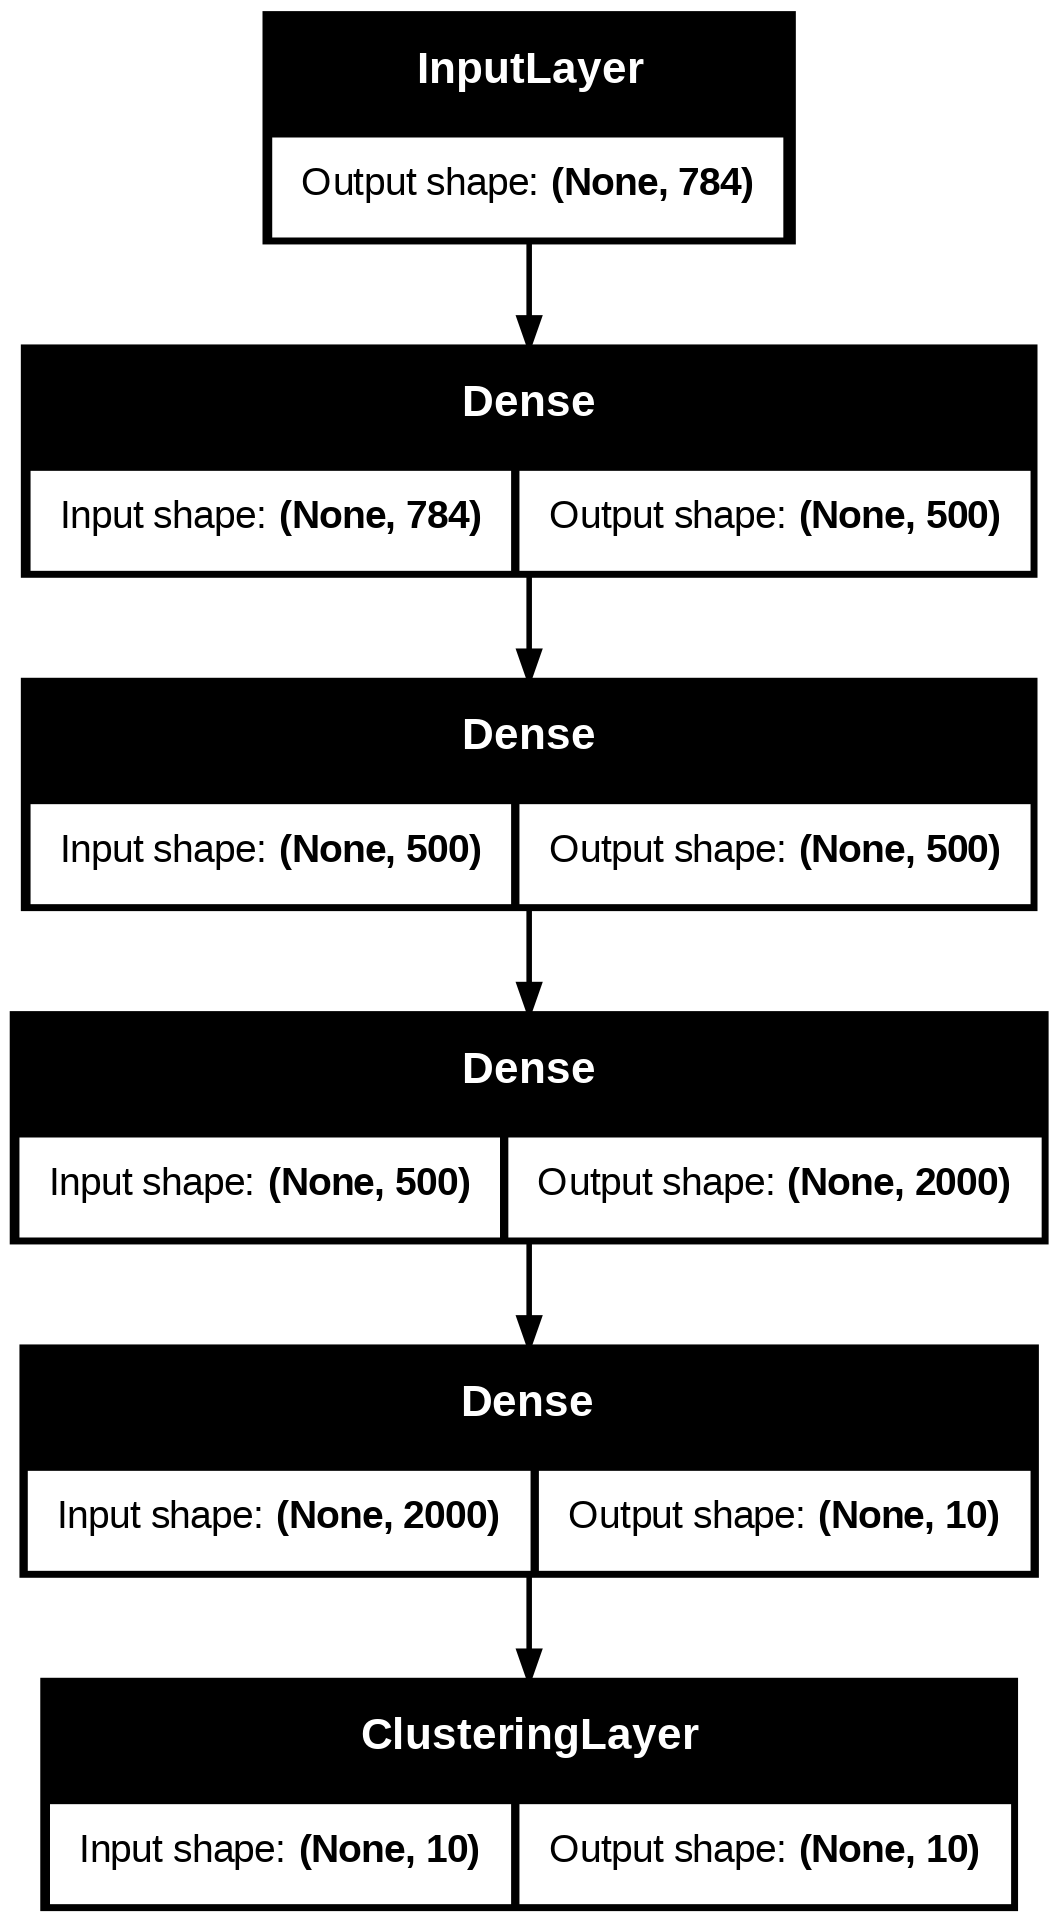

In [14]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [15]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [16]:
kmeans = KMeans(n_clusters=n_clusters, n_init=1)
y_pred = kmeans.fit_predict(encoder.predict(x))

2188/2188 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [17]:
y_pred_last = np.copy(y_pred)

In [18]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [19]:
kmeans.cluster_centers_

array([[-0.19277155, -0.94104284,  0.30293173, -2.6838923 , -0.71425295,
         0.99472845,  3.1438904 , -2.2421646 ,  0.1853044 , -2.8385553 ],
       [ 0.37554085, -2.1726823 , -0.9364798 ,  0.94311726,  0.35407758,
         1.0073272 , -1.0951152 , -0.324978  ,  0.00594983,  1.8027858 ],
       [ 1.1837887 , -1.1595123 , -3.0274105 ,  0.78694296,  1.920991  ,
        -0.1826478 ,  1.5988282 , -2.9798498 ,  2.29913   , -1.9011987 ],
       [-0.89216655, -3.4629664 , -0.6326003 ,  0.8693819 , -1.4724343 ,
         2.8058975 , -1.2815654 , -1.035353  , -0.19735327, -1.5836859 ],
       [ 1.0751398 ,  1.7944472 , -0.5434177 , -0.6295615 , -0.6377881 ,
         1.2644706 ,  2.7999334 , -0.3159051 ,  1.7114986 , -0.8599783 ],
       [-0.31943953, -1.7761648 ,  0.20591515,  0.60246694,  1.3159167 ,
        -0.80265343, -2.5793738 ,  1.0535817 , -1.6894478 ,  2.419178  ],
       [ 1.8196774 ,  0.6476693 , -1.4373367 ,  2.4573455 , -1.9585195 ,
         3.0064378 ,  3.1558564 , -0.44414276

In [20]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [21]:
loss = 0
index = 0
maxiter = 3000
update_interval = 140
index_array = np.arange(x.shape[0])

In [22]:
tol = 0.001 # tolerance threshold to stop training

In [23]:
import tensorflow as tf
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.accuracy_score(y, y_pred), 5)
            nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

Iter 0: acc = 0.09956, nmi = 0.60810, ari = 0.43855  ; loss= 0
Iter 140: acc = 0.09949, nmi = 0.61402, ari = 0.44048  ; loss= 0.11869
Iter 280: acc = 0.09816, nmi = 0.61901, ari = 0.44369  ; loss= 0.15432
Iter 420: acc = 0.09621, nmi = 0.62493, ari = 0.44912  ; loss= 0.17129
Iter 560: acc = 0.09477, nmi = 0.62658, ari = 0.45061  ; loss= 0.17957
Iter 700: acc = 0.09296, nmi = 0.62893, ari = 0.45269  ; loss= 0.18393
Iter 840: acc = 0.09170, nmi = 0.63025, ari = 0.45267  ; loss= 0.1861
Iter 980: acc = 0.09069, nmi = 0.63171, ari = 0.45422  ; loss= 0.18682
Iter 1120: acc = 0.09020, nmi = 0.63259, ari = 0.45557  ; loss= 0.18674
Iter 1260: acc = 0.08964, nmi = 0.63291, ari = 0.45663  ; loss= 0.18615
Iter 1400: acc = 0.08926, nmi = 0.63342, ari = 0.45645  ; loss= 0.18523
Iter 1540: acc = 0.08914, nmi = 0.63423, ari = 0.45753  ; loss= 0.18405
Iter 1680: acc = 0.08903, nmi = 0.63444, ari = 0.45824  ; loss= 0.18272
Iter 1820: acc = 0.08901, nmi = 0.63480, ari = 0.45800  ; loss= 0.18127
Iter 1960

In [24]:
# model.trainable_weights

In [25]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.accuracy_score(y, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.08660, nmi = 0.63404, ari = 0.45779  ; loss= 0.16886


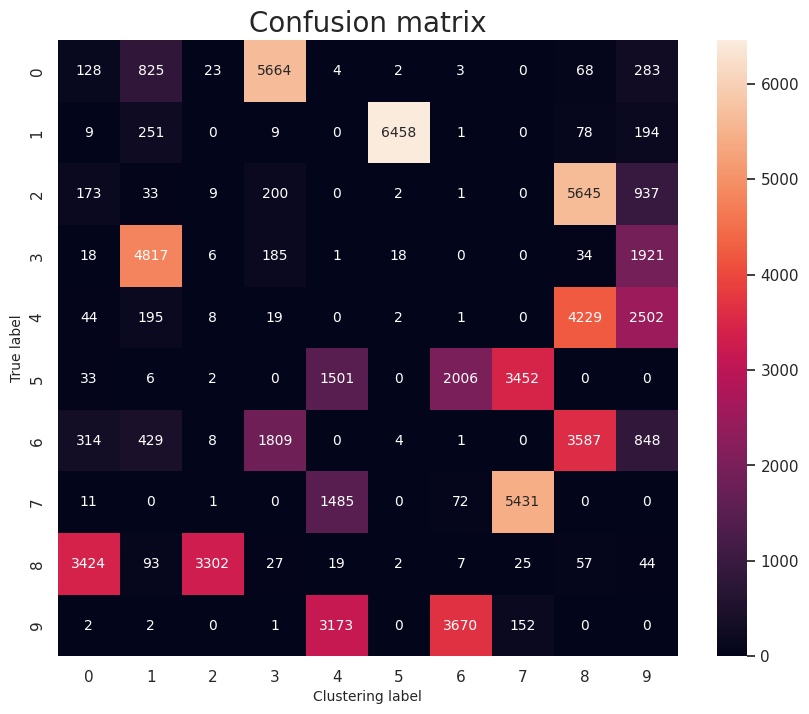

In [26]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=1)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 10});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Clustering label', fontsize=10)
plt.show()